## Pothole EDA

IIT Goa Pothole Detection & Classification Dataset

Comprehensive Road Pothole Detection and Threat Level Assessment Dataset.

In [13]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score, Metric,AUC

In [3]:
# Specify the path to your CSV file and image folder
image_folder = r'C:\Users\Broc\Documents\FLatiron\Pothole-Recognition\Unified Dataset\Unified Dataset\\'
image_folder = image_folder[:-1]
csv_file = r'C:\Users\Broc\Documents\FLatiron\Pothole-Recognition\Dataset_Info.csv'

In [4]:
df = pd.read_csv(csv_file).drop(['Unnamed: 4'],axis=1)
file_paths = df["Image ID"]

In [4]:
df

,Image ID,Pothole,Number of Potholes,Level
0,pothole_image_1299,1,3,B
1,pothole_image_10064,1,1,A
2,pothole_image_10079,1,1,A
3,pothole_image_10084,1,1,A
4,pothole_image_10087,1,2,A
...,...,...,...,...
29995,pothole_image_9990,1,2,S
29996,pothole_image_9992,1,1,S
29997,pothole_image_9993,1,1,S
29998,pothole_image_9996,1,2,S


In [5]:
# Preprocess Data Function
def preprocess_data(data_folder, csv_file, image_size, test_size=0.2, random_seed=42):
    # Step 1: Read the CSV file
    data = pd.read_csv(csv_file)

    # Step 2: Filter rows with pothole labels 0 or 1
    data = data[data['Pothole'].isin([0, 1])]

    # Step 3: Load and preprocess images using TensorFlow
    images = []
    labels = []

    for _, row in data.iterrows():
        image_path = os.path.join(data_folder, row['Image ID'] + '.jpg')
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)  # Ensure 3 color channels
        image = tf.image.resize(image, image_size)
        image = tf.image.convert_image_dtype(image, tf.float32)
        images.append(image)

        labels.append(row['Pothole'])

    # Step 4: Convert the list of TensorFlow tensors to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Step 5: Split the data into training and test sets using NumPy arrays
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_seed)

    return X_train, X_test, y_train, y_test

# Usage example:
image_size = (128, 128)  # You can adjust the image size as needed
X_train, X_test, y_train, y_test = preprocess_data(image_folder, csv_file, image_size)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [7]:
# Batch the Testing Dataset
BATCH_SIZE = 32  # You can adjust this batch size as needed
test_dataset = test_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

## Scoring Metrics
In our binary image classification project, using AUC-ROC (Area Under the Curve of the Receiver Operating Characteristic) instead of accuracy because it handles imbalanced classes better. Accuracy can be tricked when one class is way more common. AUC-ROC looks at both sensitivity and specificity, giving a better idea of how well our model can tell classes apart. This is super handy when some classes don't have as many examples.


In [8]:
# Create a simple model with the appropriate input shape to unsure our data will fit into a model
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='roc_auc')])


In [9]:
model1.fit(train_dataset, epochs = 5)

Epoch 1/5
750/750 [==============================] - 215s 284ms/step - loss: 5.4253 - roc_auc: 0.8553
Epoch 2/5
750/750 [==============================] - 213s 285ms/step - loss: 0.2940 - roc_auc: 0.9321
Epoch 3/5
750/750 [==============================] - 212s 283ms/step - loss: 0.2141 - roc_auc: 0.9661
Epoch 4/5
750/750 [==============================] - 209s 278ms/step - loss: 0.1658 - roc_auc: 0.9784
Epoch 5/5
750/750 [==============================] - 216s 288ms/step - loss: 0.1342 - roc_auc: 0.9857


188/188 [==============================] - 314s 2s/step


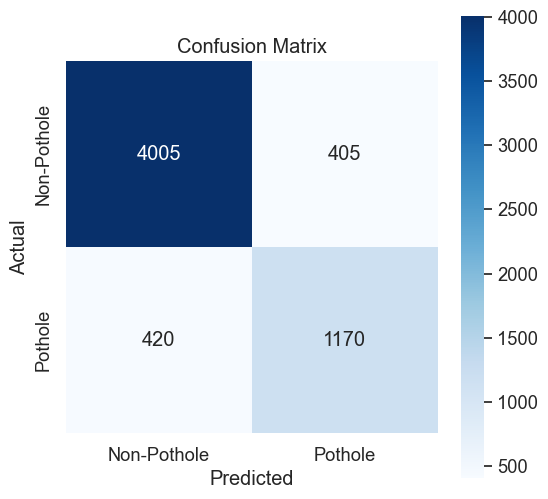

In [10]:
binary_preds  = np.round(model1.predict(test_dataset))
cm = confusion_matrix(y_test, binary_preds)

# Create a heatmap using Seaborn
sns.set(font_scale=1.2)  # Adjust font size for better readability
plt.figure(figsize=(6, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Non-Pothole', 'Pothole'], yticklabels=['Non-Pothole', 'Pothole'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [12]:
def create_cnn_model(input_shape, learning_rate=0.001, num_filters=32):
    model = Sequential()

    # Add a standardization layer to scale input features (image pixels)
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=input_shape))

    # Convolutional Layer 1
    model.add(Conv2D(num_filters, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolutional Layer 2
    model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolutional Layer 3
    model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer for Binary Classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary cross-entropy for binary classification
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Example usage:
input_shape = (128, 128, 3)  # 3 for RGB

model = create_cnn_model(input_shape)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)       

In [13]:
model.fit(train_dataset, epochs = 10)

Epoch 1/10
750/750 [==============================] - 637s 847ms/step - loss: 0.6906 - accuracy: 0.8555
Epoch 2/10
750/750 [==============================] - 656s 875ms/step - loss: 0.2884 - accuracy: 0.8989
Epoch 3/10
750/750 [==============================] - 661s 881ms/step - loss: 0.2749 - accuracy: 0.9029
Epoch 4/10
750/750 [==============================] - 676s 901ms/step - loss: 0.2632 - accuracy: 0.9068
Epoch 5/10
750/750 [==============================] - 713s 950ms/step - loss: 0.2563 - accuracy: 0.9101
Epoch 6/10
750/750 [==============================] - 703s 937ms/step - loss: 0.2485 - accuracy: 0.9120
Epoch 7/10
750/750 [==============================] - 676s 901ms/step - loss: 0.2369 - accuracy: 0.9161
Epoch 8/10
750/750 [==============================] - 676s 901ms/step - loss: 0.2264 - accuracy: 0.9169
Epoch 9/10
750/750 [==============================] - 716s 955ms/step - loss: 0.2189 - accuracy: 0.9206
Epoch 10/10
750/750 [==============================] - 702s 937m

In [14]:
preds = np.round(model.predict(test_dataset))

188/188 [==============================] - 32s 172ms/step


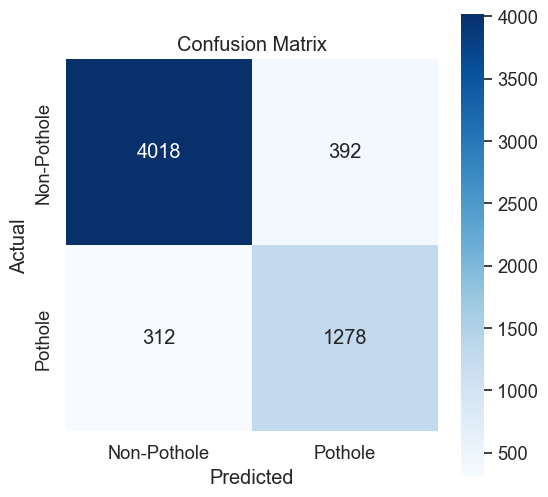

In [15]:
cm = confusion_matrix(y_test, preds)

# Create a heatmap using Seaborn
sns.set(font_scale=1.2)  # Adjust font size for better readability
plt.figure(figsize=(6, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Non-Pothole', 'Pothole'], yticklabels=['Non-Pothole', 'Pothole'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [5]:
# Preprocess Data Function
def preprocess_data(data_folder, csv_file, image_size, test_size=0.2, random_seed=42):
    # Step 1: Read the CSV file
    data = pd.read_csv(csv_file)

    # Step 2: Filter rows with pothole labels 0 or 1
    data = data[data['Number of Potholes'] < 4]


    # Step 3: Load and preprocess images using TensorFlow
    images = []
    labels = []

    for _, row in data.iterrows():
        image_path = os.path.join(data_folder, row['Image ID'] + '.jpg')
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)  # Ensure 3 color channels
        image = tf.image.resize(image, image_size)
        image = tf.image.convert_image_dtype(image, tf.float32)
        images.append(image)

        labels.append(row['Number of Potholes'])

    # Step 4: Convert the list of TensorFlow tensors to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Step 5: Split the data into training and test sets using NumPy arrays
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_seed)

    return X_train, X_test, y_train, y_test

# Usage example:
image_size = (32, 32)  # You can adjust the image size as needed
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = preprocess_data(image_folder, csv_file, image_size)

In [6]:
y_train_encoded = to_categorical(y_train_multiclass, num_classes=4)
train_multiclass = tf.data.Dataset.from_tensor_slices((X_train_multiclass, y_train_encoded))
test_multiclass = tf.data.Dataset.from_tensor_slices((X_test_multiclass, y_test_multiclass))


In [7]:
BATCH_SIZE = 32
train_multiclass = train_multiclass.batch(BATCH_SIZE)
test_multiclass = test_multiclass.batch(BATCH_SIZE)

In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 output units for 4 classes, 'softmax' activation
])

# Compile the model with appropriate settings for multiclass classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(name='roc_auc')])


In [20]:
model.fit(train_multiclass, epochs = 15)

Epoch 1/15
738/738 [==============================] - 13s 16ms/step - loss: 1.3913 - roc_auc: 0.9311
Epoch 2/15
738/738 [==============================] - 12s 16ms/step - loss: 0.5150 - roc_auc: 0.9537
Epoch 3/15
738/738 [==============================] - 12s 16ms/step - loss: 0.4572 - roc_auc: 0.9633
Epoch 4/15
738/738 [==============================] - 11s 15ms/step - loss: 0.4084 - roc_auc: 0.9704
Epoch 5/15
738/738 [==============================] - 12s 16ms/step - loss: 0.3750 - roc_auc: 0.9750
Epoch 6/15
738/738 [==============================] - 12s 16ms/step - loss: 0.3473 - roc_auc: 0.9786
Epoch 7/15
738/738 [==============================] - 12s 16ms/step - loss: 0.3239 - roc_auc: 0.9813
Epoch 8/15
738/738 [==============================] - 11s 15ms/step - loss: 0.2894 - roc_auc: 0.9848
Epoch 9/15
738/738 [==============================] - 11s 15ms/step - loss: 0.2685 - roc_auc: 0.9867
Epoch 10/15
738/738 [==============================] - 12s 16ms/step - loss: 0.2447 - roc_a

In [21]:
# Get class labels as integers
preds = np.argmax(model.predict(test_multiclass), axis=1)


185/185 [==============================] - 1s 3ms/step


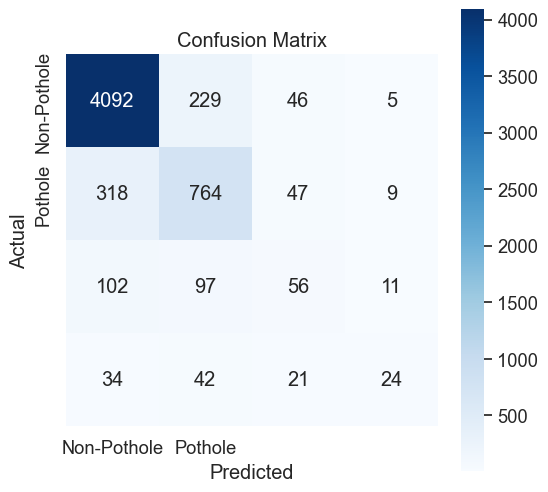

In [22]:
cm = confusion_matrix(y_test_multiclass, preds)

# Create a heatmap using Seaborn
sns.set(font_scale=1.2)  # Adjust font size for better readability
plt.figure(figsize=(6, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Non-Pothole', 'Pothole'], yticklabels=['Non-Pothole', 'Pothole'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## The categorical classification approach didn't yield as strong results as its binary counterpart, and this disparity can likely be attributed to imbalances within our dataset. To address this issue and bolster the performance of our model, we're turning to the ImageDataGenerator. 

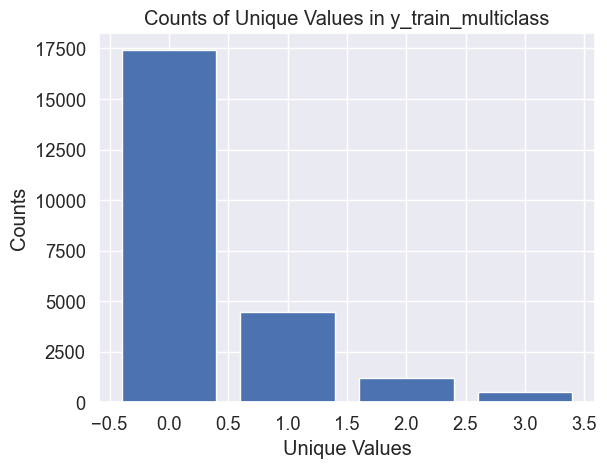

In [159]:
# Assuming y_train_multiclass is your NumPy array
unique_values, counts = np.unique(y_train_multiclass, return_counts=True)

# Create a bar chart
plt.bar(unique_values, counts)

# Add labels and a title
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Counts of Unique Values in y_train_multiclass')

# Show the plot
plt.show()


In [14]:
def oversample_train_set(X_train, y_train, target_samples=10000):
    # Calculate the target number of samples for each class (e.g., make them all equal)
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    value_counts = dict(zip(unique_classes, class_counts))

    # Create empty lists to store oversampled data
    X_oversampled = []
    y_oversampled = []

    # Loop through each class
    for class_label in unique_classes:
        # Extract data and labels for the current class
        class_data = X_train[y_train == class_label]
        class_labels = y_train[y_train == class_label]

        # Calculate how many additional samples are needed
        num_additional_samples = target_samples - len(class_data)
        if num_additional_samples > 0:
            # Create an ImageDataGenerator for augmentation (you can adjust the parameters)
            datagen = ImageDataGenerator(
                
            )

            # Generate augmented samples
            aug_data = []
            aug_labels = []
            for i in range(num_additional_samples):
                # Assuming 'class_data' contains image data in the form of arrays
                for x, y in datagen.flow(np.array(class_data), class_labels, batch_size=1):
                    aug_data.append(x[0])
                    aug_labels.append(y[0])
                    break

            # Append the augmented data to the oversampled lists
            X_oversampled.extend(aug_data)
            y_oversampled.extend(aug_labels)

    # Convert oversampled data to NumPy arrays
    X_oversampled = np.array(X_oversampled)
    y_oversampled = np.array(y_oversampled)

    # Combine oversampled data with the original train set
    X_combined = np.concatenate((X_train, X_oversampled), axis=0)
    y_combined = np.concatenate((y_train, y_oversampled), axis=0)

    # Shuffle combined data to maintain order
    X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

    return X_combined, y_combined

# Usage
X_combined_train, y_combined_train = oversample_train_set(X_train_multiclass, y_train_multiclass)


In [15]:
y_train_encoded = to_categorical(y_combined_train, num_classes=4)
train_os_dataset = tf.data.Dataset.from_tensor_slices((X_combined_train, y_train_encoded))

# Choose your desired batch size
BATCH_SIZE = 32
train_os_dataset = train_os_dataset.batch(BATCH_SIZE)

train_os_dataset.get_single_element

<bound method DatasetV2.get_single_element of <_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>>

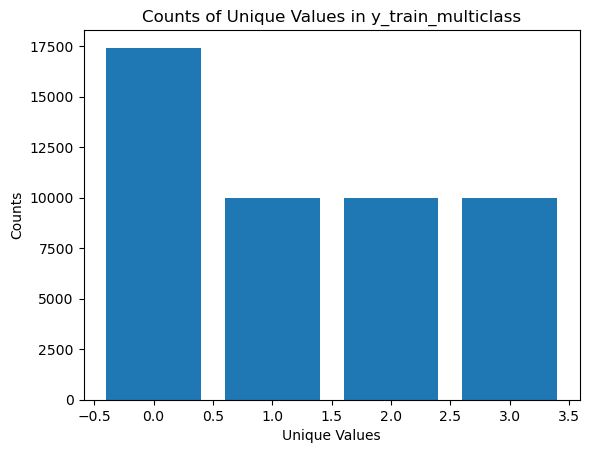

In [17]:
# Assuming y_train_multiclass is your NumPy array
unique_values, counts = np.unique(y_combined_train, return_counts=True)

# Create a bar chart
plt.bar(unique_values, counts)

# Add labels and a title
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Counts of Unique Values in y_train_multiclass')

# Show the plot
plt.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 64)                692288    
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                        

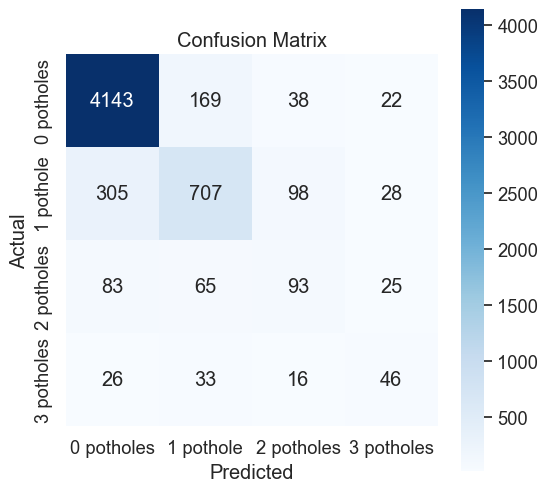

In [18]:
# Create a model for 4-class classification
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4-class output with 'softmax' activation
])

# Compile the model with appropriate loss and metrics
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(name='roc_auc')])
model2.summary()
model2.fit(train_os_dataset, epochs = 20)

preds2 = np.argmax(model2.predict(test_multiclass), axis=1)

# Assuming you have already computed the 'cm' confusion matrix
# Define labels for your classes
class_labels = ["0 potholes", "1 pothole", "2 potholes", "3 potholes"]
cm = confusion_matrix(y_test_multiclass, preds2)
# Create a heatmap using Seaborn with the updated class labels
sns.set(font_scale=1.2)  # Adjust font size for better readability
plt.figure(figsize=(6, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## Now that we've achieved improved results through oversampling our data, we're ready to progress to the next stage of our project. The enhanced dataset, which balances the class distribution, has allowed us to address class imbalance issues effectively. With this more balanced data, we can confidently advance to the next step, which involves feeding it into a more complex and sophisticated machine learning model. This upgraded model will have the capacity to capture intricate patterns and relationships within our data, further enhancing our ability to make accurate predictions and classifications.

In [19]:
def create_cnn_model(input_shape, num_classes, learning_rate=0.001, num_filters=32):
    model = Sequential()

    # Rescaling layer to scale input features (image pixels)
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=input_shape))

    # Convolutional Layer 1
    model.add(Conv2D(num_filters, kernel_size=(3, 3), activation='relu'))
    # conv (no activation), then batch_norm, then activation
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer for Multi-Class Classification
    model.add(Dense(num_classes, activation='softmax'))  # Number of classes

    # Compile the model with categorical cross-entropy for multi-class classification
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=[AUC(name='roc_auc')]
    )

    return model



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 128)        

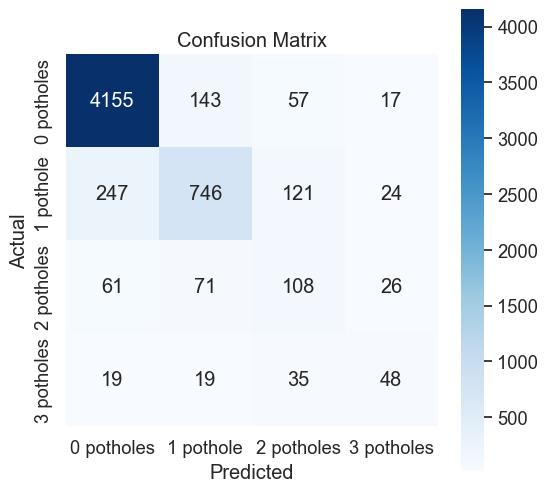

In [20]:
# Example usage for multi-class classification:
input_shape = (32, 32, 3)  # 3 for RGB
num_classes = 4  # Change this to the number of classes in your dataset
model3 = create_cnn_model(input_shape, num_classes)
model3.summary()

model3.fit(train_os_dataset, epochs = 20)
preds = np.argmax(model3.predict(test_multiclass), axis=1)
# Assuming you have already computed the 'cm' confusion matrix
# Define labels for your classes
class_labels = ["0 potholes", "1 pothole", "2 potholes", "3 potholes"]
cm = confusion_matrix(y_test_multiclass, preds)
# Create a heatmap using Seaborn with the updated class labels
sns.set(font_scale=1.2)  # Adjust font size for better readability
plt.figure(figsize=(6, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## We've achieved promising results with our most recent model. To maintain our momentum, we've decided to focus on refining the first convolutional layer by adjusting filter values.

In [22]:
def create_cnn_model(input_shape, num_classes, learning_rate=0.001, num_filters=32):
    model = Sequential()

    # Rescaling layer to scale input features (image pixels)
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=input_shape))

    # Convolutional Layer 1
    model.add(Conv2D(num_filters, kernel_size=(3, 3), activation='relu'))
    # conv (no activation), then batch_norm, then activation
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer for Multi-Class Classification
    model.add(Dense(num_classes, activation='softmax'))  # Number of classes

    # Compile the model with categorical cross-entropy for multi-class classification
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=[AUC(name='roc_auc')]
    )

    return model



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 64)         

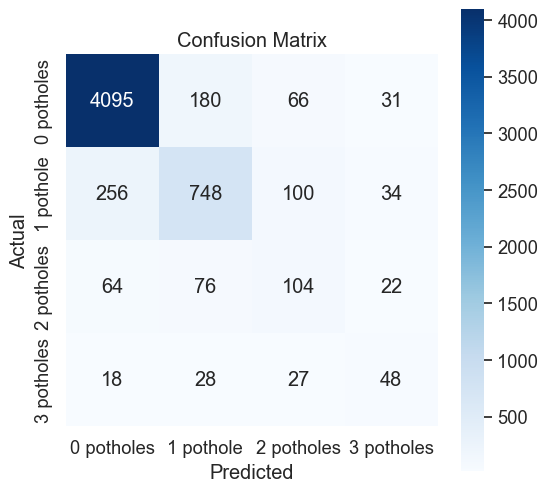

In [24]:
# Example usage for multi-class classification:
input_shape = (32, 32, 3)  # 3 for RGB
num_classes = 4  # Change this to the number of classes in your dataset
num_filters = 16 
model16 = create_cnn_model(input_shape, num_classes, num_filters = num_filters)
model16.summary()

model16.fit(train_os_dataset, epochs = 50)
preds = np.argmax(model16.predict(test_multiclass), axis=1)
# Assuming you have already computed the 'cm' confusion matrix
# Define labels for your classes
class_labels = ["0 potholes", "1 pothole", "2 potholes", "3 potholes"]
cm = confusion_matrix(y_test_multiclass, preds)
# Create a heatmap using Seaborn with the updated class labels
sns.set(font_scale=1.2)  # Adjust font size for better readability
plt.figure(figsize=(6, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 128)        

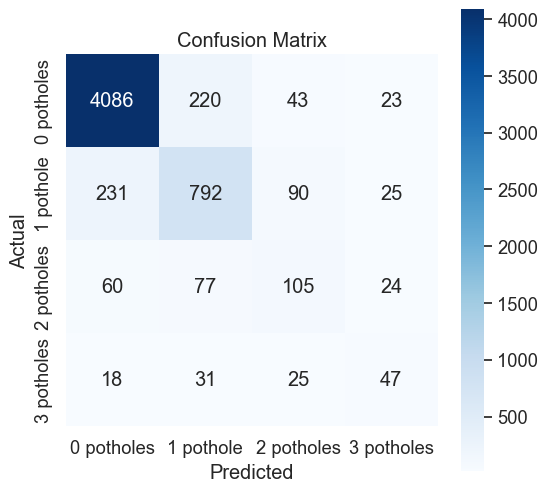

In [25]:
# Example usage for multi-class classification:
input_shape = (32, 32, 3)  # 3 for RGB
num_classes = 4  # Change this to the number of classes in your dataset
num_filters = 32 
model32 = create_cnn_model(input_shape, num_classes, num_filters = num_filters)
model32.summary()

model32.fit(train_os_dataset, epochs = 50)
preds = np.argmax(model32.predict(test_multiclass), axis=1)
# Assuming you have already computed the 'cm' confusion matrix
# Define labels for your classes
class_labels = ["0 potholes", "1 pothole", "2 potholes", "3 potholes"]
cm = confusion_matrix(y_test_multiclass, preds)
# Create a heatmap using Seaborn with the updated class labels
sns.set(font_scale=1.2)  # Adjust font size for better readability
plt.figure(figsize=(6, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [26]:
# epochs = 50
# loss_values = [1.0112, 0.9034, 0.8371, 0.7776, 0.7217, 0.6738, 0.6273, 0.5889, 0.5527, 0.5225,
#                0.4907, 0.4632, 0.4418, 0.4262, 0.4076, 0.3923, 0.3766, 0.3581, 0.3476, 0.3354,
#                0.3271, 0.3161, 0.3083, 0.3039, 0.2924, 0.2808, 0.2767, 0.2667, 0.2617, 0.2500,
#                0.2514, 0.2482, 0.2374, 0.2307, 0.2299, 0.2223, 0.2206, 0.2168, 0.2159, 0.2079,
#                0.2060, 0.2015, 0.1972, 0.1980, 0.1947, 0.1890, 0.1879, 0.1811, 0.1820, 0.1816]

# accuracy_values = [0.5319, 0.5989, 0.6351, 0.6662, 0.6942, 0.7170, 0.7355, 0.7530, 0.7697, 0.7842,
#                    0.7978, 0.8106, 0.8185, 0.8250, 0.8343, 0.8419, 0.8480, 0.8553, 0.8616, 0.8670,
#                    0.8681, 0.8735, 0.8775, 0.8807, 0.8843, 0.8895, 0.8911, 0.8953, 0.8972, 0.9019,
#                    0.9020, 0.9042, 0.9071, 0.9101, 0.9122, 0.9141, 0.9163, 0.9179, 0.9183, 0.9204,
#                    0.9208, 0.9243, 0.9255, 0.9258, 0.9272, 0.9284, 0.9298, 0.9332, 0.9331, 0.9316]

# # Create a DataFrame for Seaborn
# data = pd.DataFrame({
#     'Epoch': list(range(1, epochs + 1)) * 2,
#     'Value': loss_values + accuracy_values,
#     'Metric': (['Loss'] * epochs) + (['Accuracy'] * epochs)
# })

# # Set up the Seaborn style
# sns.set(style="whitegrid")

# # Plotting the data
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='Epoch', y='Value', hue='Metric', data=data)
# plt.title('Training Metrics Over Epochs')
# plt.show()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 6, 6, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 256)        

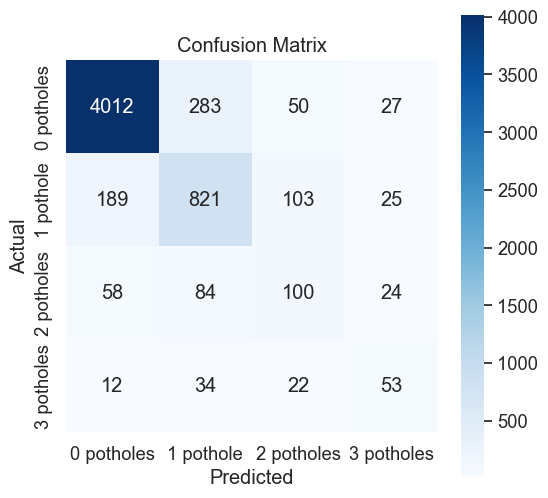

In [27]:
# Example usage for multi-class classification:
input_shape = (32, 32, 3)  # 3 for RGB
num_classes = 4  # Change this to the number of classes in your dataset
num_filters = 64  # Updated num_filters value
model64 = create_cnn_model(input_shape, num_classes, num_filters=num_filters)
model64.summary()

model64.fit(train_os_dataset, epochs=25)
preds = np.argmax(model64.predict(test_multiclass), axis=1)
# Assuming you have already computed the 'cm' confusion matrix
# Define labels for your classes
class_labels = ["0 potholes", "1 pothole", "2 potholes", "3 potholes"]
cm = confusion_matrix(y_test_multiclass, preds)
# Create a heatmap using Seaborn with the updated class labels
sns.set(font_scale=1.2)  # Adjust font size for better readability
plt.figure(figsize=(6, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()
